# Notebook for final analysis

## Import necessary libraries

In [1]:
import pandas as pd
from data.data_functions import *
from simulation.simulation_models import *
from optimization.optimization import *
import warnings

warnings.filterwarnings("ignore")

## Henter nødvendige dataset

### Timesbasert data historisk

In [2]:
dfs_dict = read_folder_to_dfs("./data/timesdata")
fin_data_hourly = create_hourly_obt(dfs_dict)
# fin_data_hourly["Belegg"] = fin_data_hourly.apply(calculate_patients, axis=1)
fin_data_hourly["skift_type"] = fin_data_hourly.apply(add_shift_type, axis=1)
fin_data_hourly.head(10)

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,skift_type
0,2020,January,1,Wednesday,2020-01-01 00:00:00,0,kirurgisk,0,1.0,0.0,natt
1,2020,January,1,Wednesday,2020-01-01 00:00:00,0,medisinsk,0,0.0,0.0,natt
2,2020,January,1,Wednesday,2020-01-01 01:00:00,1,kirurgisk,0,1.0,0.0,natt
3,2020,January,1,Wednesday,2020-01-01 01:00:00,1,medisinsk,0,1.0,0.0,natt
4,2020,January,1,Wednesday,2020-01-01 02:00:00,2,medisinsk,0,1.0,0.0,natt
5,2020,January,1,Wednesday,2020-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,natt
6,2020,January,1,Wednesday,2020-01-01 03:00:00,3,kirurgisk,0,0.0,0.0,natt
7,2020,January,1,Wednesday,2020-01-01 03:00:00,3,medisinsk,0,0.0,0.0,natt
8,2020,January,1,Wednesday,2020-01-01 04:00:00,4,kirurgisk,0,0.0,0.0,natt
9,2020,January,1,Wednesday,2020-01-01 04:00:00,4,medisinsk,0,1.0,0.0,natt


### Timesbasert prediksjoner

In [3]:
fin_data_hourly_med = fin_data_hourly[fin_data_hourly["post"]=="medisinsk"]
fin_data_hourly_kir = fin_data_hourly[fin_data_hourly["post"]=="kirurgisk"]

fin_data_hourly_med["Belegg"] = fin_data_hourly_med.apply(calculate_patients, axis=1)
fin_data_hourly_kir["Belegg"] = fin_data_hourly_kir.apply(calculate_patients, axis=1)

next_year_med = create_forecast_hourly(fin_data_hourly_med, "medisinsk")
next_year_kir = create_forecast_hourly(fin_data_hourly_kir, "kirurgisk")

next_year = pd.concat([next_year_med, next_year_kir], axis=0).sort_values("DatoTid").reset_index()
next_year.drop(["index"], axis=1, inplace=True)
next_year["skift_type"] = next_year.apply(add_shift_type, axis=1)

fin_data_hourly["Prediksjoner pasientstrøm"] = np.nan
fin_data_hourly["Prediksjoner belegg"] = np.nan

fin_data_hourly = pd.concat([fin_data_hourly_med, fin_data_hourly_kir, next_year], axis=0).sort_values("DatoTid").reset_index()
fin_data_hourly.drop(["index"], axis=1, inplace=True)

### Historisk data daglig aggregering

In [4]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data_hist = datalast_behandling(path)

### Predikerte data daglig aggregering

In [ ]:
path_pred = "./forecasting/excel_models/fin_hf_prediksjoner.xlsx"
sheetname_med = "hammerfest_medisinsk"
sheetname_kir = "hammerfest_kirurgisk"
forecasted_demand = create_forecast_dataset(path_pred, sheetname_med, sheetname_kir)

fin_data = pd.concat([fin_data_hist, forecasted_demand], axis=0).sort_values("Dato").reset_index()
fin_data.drop(["index"], axis=1, inplace=True)

### Setter felles parametere

In [ ]:
data = fin_data_hourly
post = "medisinsk"
weekend = False
predictions = False
year = [2022,2023]
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
# shifts_per_day = 3  # Antall skift per dag
iterations = 1000  # Antall simuleringer
month = ["January", "February", "March", "April", "May", "June", "July", "August", "September"]
shift_type = "kveld"
scenario = None
total_beds = 26 # 26 hvis ukedag eller helg med, kir: hverdag = 22, helg = 17
curr_sit = 12
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3

# Tilbudsiden

## Optimeringsmodell for optimalt bemanningsnivå

### Optimaliseringsdata, Modellbygging & Resultater

In [5]:
data_opt = opt_dataset(dataset=data, post=post, year=year, shift_type=shift_type, month=month, weekend=weekend, predictions=predictions)
data_opt = data_opt.apply(nightshift_weight, axis=1)

# Parameters for specific model
df_index = data_opt.DatoTid
demand = round(data_opt["Belegg"])
MaxStaff = 15
PPS = 3
availability = 40
ServiceLevel = 0.8

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level
# for å simulere de ulike scenarioene 

model = labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel)
result, status, obj, staff_allocated = optimize_staffing(model)
data_opt["staff_allocated"] = staff_allocated
data_opt = data_opt.apply(adjust_staff, axis=1)
display(data_opt) 

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JOACHI~1\AppData\Local\Temp\tmpskhof9w3.glpk.raw --wglp
 C:\Users\JOACHI~1\AppData\Local\Temp\tmpekya269e.glpk.glp --cpxlp C:\Users\JOACHI~1\AppData\Local\Temp\tmpwu3rapwy.pyomo.lp
Reading problem data from 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpwu3rapwy.pyomo.lp'...
9360 rows, 3120 columns, 9360 non-zeros
3120 integer variables, none of which are binary
46810 lines were read
Writing problem data to 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpekya269e.glpk.glp'...
37443 lines were written
GLPK Integer Optimizer 5.0
9360 rows, 3120 columns, 9360 non-zeros
3120 integer variables, none of which are binary
Preprocessing...
Objective value =   1.494300000e+04
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 4.6 Mb (4835188 bytes)
Writing MIP solution to 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpskhof9w3.glpk.raw'...
12489 lines were written


,DatoTid,Timer,skift_type,Antall inn på post,Belegg,staff_allocated
0,2022-01-03 07:00:00,7,dag,0.0,19.0,6.0
1,2022-01-03 08:00:00,8,dag,0.0,19.0,6.0
2,2022-01-03 09:00:00,9,dag,1.0,20.0,6.0
3,2022-01-03 10:00:00,10,dag,0.0,20.0,6.0
4,2022-01-03 11:00:00,11,dag,0.0,20.0,6.0
...,...,...,...,...,...,...
3115,2023-09-29 10:00:00,10,dag,0.0,23.0,7.0
3116,2023-09-29 11:00:00,11,dag,0.0,23.0,7.0
3117,2023-09-29 12:00:00,12,dag,0.0,23.0,7.0
3118,2023-09-29 13:00:00,13,dag,0.0,18.0,5.0


### Visualize results

In [ ]:
# Med post: hverdag: dag: 12, kveld: 12, natt:4 
# Med post: Helg: 9, 9, 4
# Kir post: Hverdag: 10, 8, 3
# Kir post: Helg: 8, 7, 3
fin = 12

# Med post: hverdag: dag: 10, kveld: 7, natt:4 
# Med post: Helg: 9, 7, 4
# Kir post: Hverdag: 10, 8, 4
# Kir post: Helg: 8, 8, 3
siv = 10

# Med post: hverdag: dag: 16, kveld: 9, natt:6 
# Med post: Helg: ?, ?, ?
# Kir post: Hverdag: 18, 11, 5
# Kir post: Helg: ?, ?, ?
unn = 9
staff_allocated = data_opt["staff_allocated"].tolist()
# date_list = data_opt['DatoTid'].tolist()
staff_opt_plot(staff_allocated, fin, siv, unn, dag=True)

## Optimeringsmodell for minimering av kostnader

### Preprocessing

In [ ]:
import math
data_opt["HourCost"] = data_opt.apply(lambda x: hourly_cost_calc(x), axis=1)
opt_cost_data = data_opt.groupby(["Timer", "skift_type"])[["staff_allocated", "HourCost"]].mean().reset_index()
opt_cost_data["staff_allocated"] = opt_cost_data["staff_allocated"].apply(lambda x: math.ceil(x))
hour_list = list(opt_cost_data["Timer"])
numEmp_list = [element for element in opt_cost_data["staff_allocated"]]
cost_list = [int(element) for element in opt_cost_data["HourCost"]]

df_index = hour_list
numEmp = numEmp_list
shifts = ["dag", "kveld", "natt"]
shiftLengths = [4,5,6,7,8,9,10,11,12]
hourly_cost = cost_list

### Model

In [ ]:
shifts, cost = opt_cost_model(df_index=df_index, numEmp=numEmp, shifts=shifts, shiftLengths=shiftLengths, hourly_cost=hourly_cost)

## Simulering Skiftdesign for Over- og Underbemanninger

### Input data

In [ ]:
data = fin_data_hourly
post = "medisinsk"
weekend = False
predictions = False
year = [2024]
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
iterations = 1000  # Antall simuleringer
month = ["January", "February"] # ,"March", "April", "May", "June", "July", "August", "September" 
shift_type = None
staff_needed = 0
curr_sit = 9
shifts_per_day = 24  # Antall timer per dag

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig, 5) evt. to shift helg istedet for 3 (?)
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# og avg_length_of_stay, (shifts_per_day) for å simulere de ulike scenarioene  

## Behovsmodellen

In [5]:
# understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data = over_under_staffed_shifts(data=data,
sim_avg_nurses, data_sim = over_under_staffed_shifts(data=data,
                                                                                                       staff_needed= staff_needed, 
                                                                                                       avg_length_of_stay= avg_length_of_stay, 
                                                                                                       shifts_per_day= shifts_per_day, 
                                                                                                       iterations= iterations, 
                                                                                                       post=post, 
                                                                                                       weekend=weekend, 
                                                                                                       predictions=predictions, 
                                                                                                       year=year,
                                                                                                       month=month,
                                                                                                       shift_type=shift_type,
                                                                                                       curr_sit = curr_sit)



In [9]:
sum(data_sim["Belegg"])/len(data_sim["Belegg"])

13.071794871794872

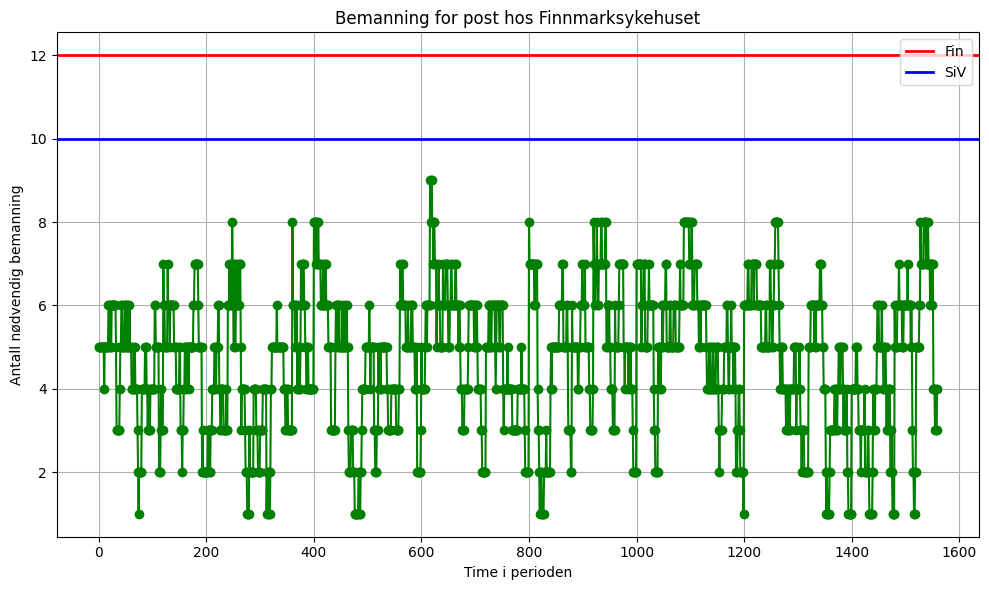

In [6]:
#test
fin = 12
siv = 10
unn = 9

# staff_allocated = data_opt["staff_allocated"].tolist()
sim_avg_nurses = list(map(lambda x: 1 if x == 0 else x, sim_avg_nurses))
staff_opt_plot(sim_avg_nurses, fin, siv, unn, dag=True)

In [7]:
test_df = fin_data_hourly[(fin_data_hourly["År"] == 2024) & (fin_data_hourly["post"] == "kirurgisk")
                & (fin_data_hourly["skift_type"] == "natt") & (fin_data_hourly["helg"] == 1)]

month = ["January", "February","March", "April", "May", "June", "July", "August", "September"]
data = test_df.query(f"Måned in {month}")

In [8]:
needed_nurses_intensity = []

belegg = data["Belegg"].tolist()
nurses_min = [2]*len(belegg)
PPP = 6
for b, n_min in zip(belegg, nurses_min):
    SI = b / (n_min * PPP) 
    needed_nurses_intensity.append(SI)

In [9]:
needed_nurses_intensity_rounded = [round(intensity, 2) for intensity in needed_nurses_intensity]

In [10]:
avg = sum(needed_nurses_intensity_rounded)/len(needed_nurses_intensity_rounded)
avg

1.2785096153846116

In [11]:
over = []
correct = []
for i in needed_nurses_intensity_rounded:
    if i > 1:
        over.append(i)
    else:
        correct.append(i)

pct_over = len(over)/len(needed_nurses_intensity_rounded)*100
pct_over

78.68589743589743

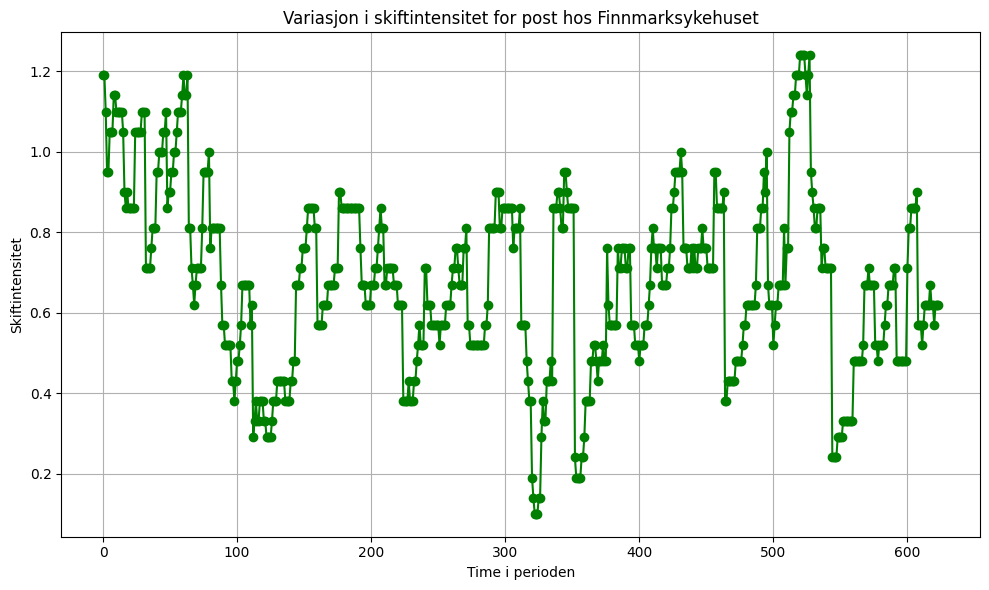

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(needed_nurses_intensity_rounded, marker='o', color='g', linestyle='-')
# plt.axhline(y=fin, color="r", linewidth = 2, linestyle = "-", label = "Fin")
# plt.axhline(y=siv, color="b", linewidth = 2, linestyle = "-", label = "SiV")
# if not dag:
#     plt.axhline(y=unn, color="y", linewidth = 2, linestyle = "-", label = "UNN")
plt.title('Variasjon i skiftintensitet for post hos Finnmarksykehuset')
plt.xlabel('Time i perioden')
plt.ylabel('Skiftintensitet')
plt.grid(True)
plt.tight_layout()
# plt.legend(loc = "upper right")
plt.show()


## Verifiseringsmodellen

Prosentandel timer med underbemanning: 0.00%
Prosentandel timer med overbemanning: 100.00%
Prosentandel timer med riktig bemanning: 0.00%


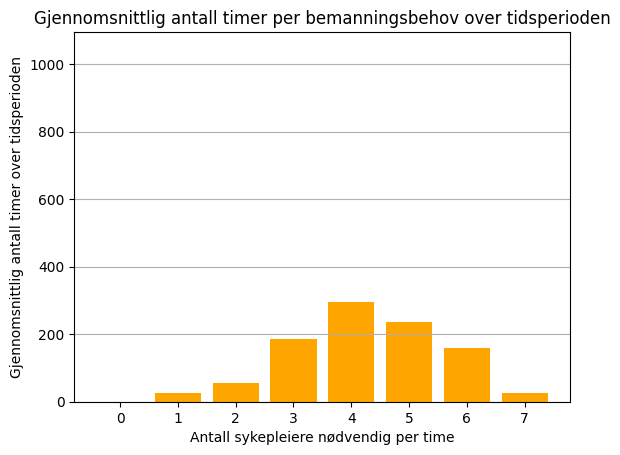

In [6]:
nurses_needed_per_shift = sim_avg_nurses
actual_nurses = curr_sit          
total_shifts = len(nurses_needed_per_shift)
understaffed_shifts = 0
overstaffed_shifts = 0

for nurse in sim_avg_nurses:
    if nurse > actual_nurses:
        understaffed_shifts += 1
    elif nurse < actual_nurses:
        overstaffed_shifts += 1


prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100
prosent_riktig_bemannet = 100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)
prosent_til_figur = prosent_overbemannet_skift + prosent_riktig_bemannet


# Resultat: Hvor ofte er skift underbemannet?
print(f"Prosentandel timer med underbemanning: {prosent_underbemannet_skift:.2f}%")
print(f"Prosentandel timer med overbemanning: {prosent_overbemannet_skift:.2f}%")
print(f"Prosentandel timer med riktig bemanning: {(100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)):.2f}%")
under_over_staffing_plot(sim_avg_nurses, iterations, shifts_per_day)

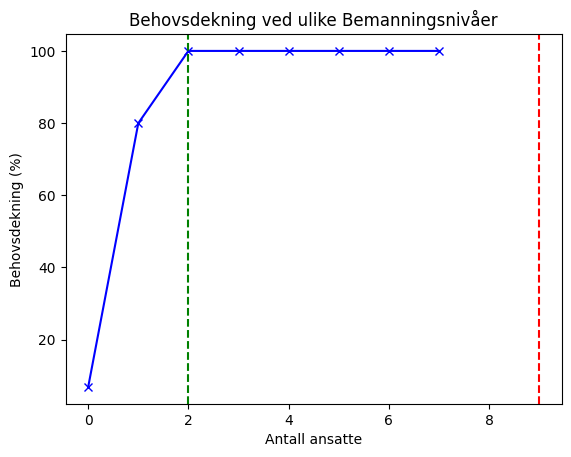

In [6]:
nurses_needed_per_shift = sim_avg_nurses
actual_nurses = [i for i in range(max(nurses_needed_per_shift) + 6)]             
total_shifts = len(nurses_needed_per_shift)
staff_dict = {}

for staffing in actual_nurses:
    understaffed_shifts = 0
    overstaffed_shifts = 0
    for nurse in sim_avg_nurses:
        if nurse > staffing:
            understaffed_shifts += 1
        elif nurse < staffing:
            overstaffed_shifts += 1


    prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
    prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100
    prosent_riktig_bemannet = 100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)
    prosent_til_figur = prosent_overbemannet_skift + prosent_riktig_bemannet
    staff_dict[staffing] = prosent_til_figur

# staff_dict = {key: value for key, value in staff_dict.items() if value > 95}
staffing = list(staff_dict.keys())
coverage = list(staff_dict.values())

staffing_exceeding_90 = next(key for key, value in staff_dict.items() if value > 95)
plt.plot(staffing, coverage, marker='x', linestyle='-', color='b')

plt.axvline(x=curr_sit, color='r', linestyle='--', label='x=12')
plt.axvline(x=staffing_exceeding_90, color='g', linestyle='--', label=f'Staffing > 90%: x={staffing_exceeding_90}')

plt.xlabel('Antall ansatte')
plt.ylabel('Behovsdekning (%)')
plt.title('Behovsdekning ved ulike Bemanningsnivåer')
plt.grid(False)
plt.show()


## Bemanningsmodellen

In [ ]:
len(pd.date_range(start='2024-01-01 00:00', end='2024-02-28 23:00', freq='H'))
sim_avg_nurses = [i for i in range(1,1417)]

1416

In [2]:
sim_avg_nurses = [i for i in range(1,1417)]

In [3]:
# Lage (foreløpig) dummydata for ansatte og stillingsprosenter

# Ansatte
employees = list(range(1, 41))

# Stillingsprosenter
values = [1.0] * 40 + [0.5] * 0 #+ [0.5] * 2 + [0.4] * 1
np.random.shuffle(values)

emp_pospct_df = pd.DataFrame({
    'Ansatt': employees,
    'Stillingsprosent': values
})


datetime_range = pd.date_range(start='2024-01-01 00:00', end='2024-02-28 23:00', freq='H')
df = pd.DataFrame({'Datetime': datetime_range})
df["År"] = df['Datetime'].dt.year
df["Måned"] = df['Datetime'].dt.month_name()
df["Dag"] = df["Datetime"].dt.day_name()
df["Uke"] = df["Datetime"].dt.isocalendar().week
df['helg'] = df['Datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df["Timer"] =df['Datetime'].dt.hour
df["Timer"] = df["Timer"].astype(int)
df["skift_type"] = df.apply(add_shift_type, axis=1)

num_weeks = max(df["Uke"].tolist())
emp_pospct_df['Weekend_Work'] = 3
emp_pospct_df['7Day_Working_Hours'] = 40
emp_pospct_df["Max_Work_Hours"] = emp_pospct_df["Stillingsprosent"] * 35 * num_weeks

# sim_avg_nurses +=[5,4,3,6,5,4]*4
df['demand'] = sim_avg_nurses
df['dato'] = df['Datetime'].dt.date
df['day_of_year'] = df['Datetime'].dt.dayofyear
result = df.groupby(['dato',"Uke","day_of_year", 'Dag', 'skift_type'])['demand'].max().reset_index()

In [5]:
def update_demand(row):
    if row['Dag'] in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]: 
        if row['skift_type'] == 'dag':
            return 7
        elif row['skift_type'] == 'kveld':
            return 7
        elif row['skift_type'] == 'natt':
            return 3
    elif row['Dag'] in ["Saturday", "Sunday"]:
        if row['skift_type'] == 'dag':
            return 4
        elif row['skift_type'] == 'kveld':
            return 5
        elif row['skift_type'] == 'natt':
            return 2
    return row['demand']

result['demand'] = result.apply(update_demand, axis=1)

In [6]:
display(result)
display(emp_pospct_df)
# TODO: Make this but manage to include every day (including weekends) + all types of shifts. Most likely you would need to include everything in the behovsmodell,
# TODO: but when showing in graphs etc. then you filter on what you want to see. Then you can have the complete dataset always.


,dato,Uke,day_of_year,Dag,skift_type,demand
0,2024-01-01,1,1,Monday,dag,7
1,2024-01-01,1,1,Monday,kveld,7
2,2024-01-01,1,1,Monday,natt,3
3,2024-01-02,1,2,Tuesday,dag,7
4,2024-01-02,1,2,Tuesday,kveld,7
...,...,...,...,...,...,...
172,2024-02-27,9,58,Tuesday,kveld,7
173,2024-02-27,9,58,Tuesday,natt,3
174,2024-02-28,9,59,Wednesday,dag,7
175,2024-02-28,9,59,Wednesday,kveld,7


,Ansatt,Stillingsprosent,Weekend_Work,7Day_Working_Hours,Max_Work_Hours
0,1,1.0,3,40,315.0
1,2,1.0,3,40,315.0
2,3,1.0,3,40,315.0
3,4,1.0,3,40,315.0
4,5,1.0,3,40,315.0
5,6,1.0,3,40,315.0
6,7,1.0,3,40,315.0
7,8,1.0,3,40,315.0
8,9,1.0,3,40,315.0
9,10,1.0,3,40,315.0


In [7]:
demand = result["demand"]
days = [0,1,2,3,4,5,6]
shifts = ['Dag', 'Kveld', 'Natt'] # , 'Fri'
employees = emp_pospct_df['Ansatt'].tolist()
position_percentage = emp_pospct_df['Stillingsprosent'].tolist()
weeks = list(set(result["Uke"].tolist()))
day_of_year = list(set(df['day_of_year'].tolist()))
shift_lengths = [8,8,8]
weekend_work = emp_pospct_df['Weekend_Work'].tolist()
weekly_hours = emp_pospct_df['7Day_Working_Hours'].tolist()
max_workinghours = emp_pospct_df["Max_Work_Hours"].tolist()

In [8]:
from collections import OrderedDict, defaultdict

def opt_staffing_model(demand: list, days: list, shifts: list, employees: list, position_percentage: list, weeks: list, day_of_year:list, shift_lengths: list, 
                       weekend_work: list, weekly_hours: list, max_workinghours: list):
    

    model = pyo.ConcreteModel()

    #### Sets ####
    model.Shift_type = pyo.Set(initialize=shifts)
    model.Employees = pyo.Set(initialize = employees)
    model.Days = pyo.Set(initialize = days)
    model.Week = pyo.Set(initialize = weeks)
    model.DoY = pyo.Set(initialize = day_of_year)



    ## Parameters ##

    # Bemanningsbehov
    behov_dict = {
        (shift, day): int(demand[(day - 1) * len(shifts) + shift_idx])
        for day in day_of_year
        for shift_idx, shift in enumerate(shifts)
    }
    behov_dict = OrderedDict(sorted(behov_dict.items(), key=lambda x: x[0][1]))
    behov_dict = dict(behov_dict)

    model.B = pyo.Param(model.Shift_type, model.DoY, initialize = behov_dict, within = pyo.Integers)
    B = model.B # Bemanningsbehov

    
    
    # Stillingsstr
    position_percentage_dict = {
    employees[i]: position_percentage[i]
    for i in range(len(employees))
    }

    model.SP = pyo.Param(model.Employees, initialize = position_percentage_dict, within = pyo.PercentFraction)
    SP = model.SP # Stillingsprosent

    
    
    # Shift varighet

    hours_dict = {}
    for shift_idx, shift in enumerate(shifts): # [:-1]
        hours_dict[shift]= shift_lengths[shift_idx]
    # hours_dict["Fri"] = 0

    model.H = pyo.Param(model.Shift_type, initialize = hours_dict, within = pyo.Integers)
    H = model.H # Hours
    

    
    # Weekend work
    weekend_work_dict = {
    employees[i]: weekend_work[i]
    for i in range(len(employees))
    }
    model.WW = pyo.Param(model.Employees, initialize = weekend_work_dict, within = pyo.Integers) 
    WW = model.WW # Weekend Work --> Brukes ikke!?



    # Maximum working hour during a week
    weekly_hours_dict = {
    employees[i]: weekly_hours[i]
    for i in range(len(employees))
    }    
    model.WH = pyo.Param(model.Employees, initialize = weekly_hours_dict, within = pyo.Integers) 
    WH = model.WH # Weekly Hours

    
    
    # Maximum working hours during planning horizon
    maxhours_dict = {
    employees[i]: max_workinghours[i]
    for i in range(len(employees))
    }
    model.MaxWH = pyo.Param(model.Employees, initialize = maxhours_dict, within = pyo.NonNegativeReals) 
    MaxWH = model.MaxWH # Maximum Working Hours --> Bruker ikke denne foreløpig?!



    # Number of weekends in period 
    model.MWEL = pyo.Param(initialize = max(weeks), within = pyo.Integers)
    MWEL = model.MWEL



    ## Decision Variables ##
    
    ## Binary variable indicating if employee e works shift type s on day of year n
    model.x = pyo.Var(model.Employees, model.Shift_type, model.DoY, within=pyo.Binary)
    x = model.x # Employee allocation variable

    # # Minimum employees needed
    model.z = pyo.Var(model.Employees, within=pyo.Binary)
    z = model.z

   # Aux variable for å lagre summen av skift for hver ansatt over en viss periode
    model.work_in_window = pyo.Var(model.Employees, model.DoY, within=pyo.NonNegativeIntegers)

   # Aux variable for å lagre summen av helgeshift for hver ansatt
    model.weekend_shifts = pyo.Var(model.Employees, model.DoY, domain=pyo.NonNegativeIntegers)
    


    ## Objective Function ##
    model.obj_min_staff = pyo.Objective(expr= sum(SP[e]*z[e] for e in model.Employees), sense=pyo.minimize)  #antall ansatte som trengs



    ## Constraints ## 

    # Demand constraint
    model.C1 = pyo.ConstraintList()
    for s in model.Shift_type:
        for n in model.DoY: 
            model.C1.add(expr = sum(x[e,s,n] for e in model.Employees) >= B[s,n])

    # Max working hours in timeperiod
    model.MaxHours = pyo.ConstraintList()
    for e in model.Employees:
        model.MaxHours.add(expr=sum(H[s]*x[e,s,n] for s in model.Shift_type for n in model.DoY) <= MaxWH[e])
    

    employees_by_contract_size = defaultdict(list)
    for e in model.Employees:
        employees_by_contract_size[SP[e]].append(e)

    # Ensure each group is sorted
    for group in employees_by_contract_size.values():
        group.sort()

    # Add symmetry-breaking constraints
    model.C_symmetry_breaking = pyo.ConstraintList()
    for c, employees in employees_by_contract_size.items():
        for i in range(1, len(employees)):
            prev_employee = employees[i - 1]
            current_employee = employees[i]
            model.C_symmetry_breaking.add(expr=z[prev_employee] <= z[current_employee])


    # Obj.fct. constraint
    M = len(demand)
    model.C2 = pyo.ConstraintList()
    for e in model.Employees:
        model.C2.add(expr=sum(x[e,s,n] for s in model.Shift_type for n in model.DoY) <= z[e]*M)

    
    # # Required Rest
    # model.C4 = pyo.ConstraintList() # denne fjernes fordi den blir dekket av påfølgende skift constraint lenger ned
    # for e in model.Employees:
    #     for n in model.DoY:
    #         # if n >= 2:
    #         model.C4.add(expr = x[e,"Natt", n] + sum(x[e,s,n] for s in model.Shift_type if s == "Dag" or s == "Kveld") <= 1)

    model.C5 = pyo.ConstraintList()
    for e in model.Employees:
        for n in model.Days:
            if n >= 2:
                model.C5.add(expr=x[e,"Kveld",n-1] + x[e,"Natt",n] <= 1)
            
    # model.C6 = pyo.ConstraintList() # denne fjernes fordi ikke lenger inkluderer "fri" som en skift type
    # for e in model.Employees:
    #     for w in model.Week:
    #         model.C6.add(expr=sum(x[e,"Fri", n] for n in model.DoY) >= 1)
    
    
    
    seven_day_windows = {n: list(range(n-6, n+1)) for n in model.DoY if n >= 7}
    
    # 7 day period working hours constraint
    model.C3 = pyo.ConstraintList()
    for e in model.Employees:
        for n, window in seven_day_windows.items(): 
            model.C3.add(
                expr=sum(H[s] * x[e, s, n_range] for s in model.Shift_type for n_range in window) <= WH[e]
            )
    
    model.C7 = pyo.ConstraintList()
    for e in model.Employees:
        for n in seven_day_windows:
            model.C7.add(expr=model.work_in_window[e, n] == sum(x[e, s, n_range] for s in model.Shift_type for n_range in seven_day_windows[n]))
            model.C7.add(expr=model.work_in_window[e, n] <= 6) 

    # # Weekends
    
    # Work sunday = work saturday
    weekend_days = {n: True for n in model.DoY if n % 7 == 0}
    model.C8 = pyo.ConstraintList()
    for e in model.Employees:
        for n in weekend_days: 
            prev_day = n - 1  
            curr_day = n      
            # Sum over alle shift typer for å sjekke at employee jobber både lør og søn
            model.C8.add(
                expr=sum(x[e, s, prev_day] for s in model.Shift_type) >= 
                sum(x[e, s, curr_day] for s in model.Shift_type)
            )

    # Tredjehver helg 
    model.C9 = pyo.ConstraintList()
    for e in model.Employees:
        for n in weekend_days:
            # Auxiliary variabel som representerer summen av shift jobbet for ansatt e på helgdag n
            model.C9.add(expr=model.weekend_shifts[e, n] == sum(x[e, s, n] for s in model.Shift_type))
    # Sørg for at hver ansatt jobber 1/3 av alle helgedager
        model.C9.add(
            expr=sum(model.weekend_shifts[e, n] for n in model.DoY if n in weekend_days) == int(MWEL / 3)
    )

    # Maks tre natt på rad
    model.C10 = pyo.ConstraintList()
    for e in model.Employees:
        for n in model.DoY:
            if n >= 4:
                model.C10.add(expr=x[e,"Natt", n] + x[e,"Natt",n-1] + x[e,"Natt",n-2] + x[e,"Natt",n-3] <= 3)

    # Påfølgende skift etter natt
    model.C11 = pyo.ConstraintList()
    for e in model.Employees:
        for n in model.DoY:
            # if n >= 2:
            model.C11.add(expr=x[e,"Natt",n] + x[e,"Dag",n] + x[e,"Kveld",n] <= 1)



    opt = SolverFactory('glpk')
    opt.options["tmlim"] = 600
    # opt.options["mipgap"] =0.05
    status = opt.solve(model, tee=True) # , keepfiles = True, logfile="glpk.log", solnfile="solution.sol"
    # model.pprint()

    if status.solver.termination_condition in [TerminationCondition.optimal, TerminationCondition.feasible]:
        print("Løsning funnet!")
        # Retrieve objective value
        obj = pyo.value(model.obj_min_staff)
        staff_allocated = {}
        for i in model.x:
            staff_allocated[i] = pyo.value(model.x[i])
        return None, status, obj, staff_allocated



    # Retrieve staff allocated for each shift
    # staff_allocated = [pyo.value(x[e,s,n]) for e in model.Employees for s in model.Shift_type for n in model.DoY]


    # Check if the model was solved successfully
    if status.solver.termination_condition != TerminationCondition.optimal:
        print("Solver did not converge to an optimal solution.")


    return None, status, None, None

In [ ]:

result, status, obj, staff_allocation = opt_staffing_model(demand=demand, days=days, shifts=shifts,
                                                           employees=employees, position_percentage=position_percentage,
                                                           weeks=weeks, day_of_year = day_of_year, shift_lengths=shift_lengths, weekend_work=weekend_work,
                                                           weekly_hours=weekly_hours, max_workinghours=max_workinghours)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --tmlim 600 --write C:\Users\JOACHI~1\AppData\Local\Temp\tmpp0nu3s4u.glpk.raw
 --wglp C:\Users\JOACHI~1\AppData\Local\Temp\tmp4cszm26y.glpk.glp --cpxlp
 C:\Users\JOACHI~1\AppData\Local\Temp\tmpici93anx.pyomo.lp
Reading problem data from 'C:\Users\JOACHI~1\AppData\Local\Temp\tmpici93anx.pyomo.lp'...
C:\Users\JOACHI~1\AppData\Local\Temp\tmpici93anx.pyomo.lp:183057: warning: lower bound of variable 'x2' redefined
C:\Users\JOACHI~1\AppData\Local\Temp\tmpici93anx.pyomo.lp:183057: warning: upper bound of variable 'x2' redefined
12136 rows, 9560 columns, 134598 non-zeros
9560 integer variables, 7120 of which are binary
190177 lines were read
Writing problem data to 'C:\Users\JOACHI~1\AppData\Local\Temp\tmp4cszm26y.glpk.glp'...
168473 lines were written
GLPK Integer Optimizer 5.0
12136 rows, 9560 columns, 134598 non-zeros
9560 integer variables, 7120 of which are binary
Preprocessing...
2240 hidden covering inequaliti(

In [26]:
for staff, allocation in staff_allocation.items():
    print(staff, allocation)

AttributeError: 'NoneType' object has no attribute 'items'

In [45]:
employees = sorted(set(employee for employee, shift_type, day in staff_allocation.keys()))
emp_dict = {}
emp_dict = {employee: [] for employee in employees}
for (employee, shift_type, day), value in staff_allocation.items():
    if value == 1: 
        emp_dict[employee].append(value) 


In [46]:
data = []
for employee, shifts in emp_dict.items():
    data.append({'ansatt': employee, 'antall_skift': sum(shifts)})

# Opprett DataFrame
df = pd.DataFrame(data)

In [47]:
df["Stillingsprosent"] = emp_pospct_df["Stillingsprosent"]

In [48]:
df["Timer jobbet"] = df["antall_skift"]*8

In [49]:
timer_i_årsverk = 315

# Legg til en kolonne for årsverksandel per ansatt
df['årsverksandel'] = df['Timer jobbet'] / timer_i_årsverk

# Summer årsverksandeler for å finne totalt antall årsverk brukt
totalt_årsverk = df['årsverksandel'].sum()

In [3]:
'''
50% antall: årsverk (for januar + febraur)
0: 23
3: 19
6: 16
9: 15
12: 13
15: 11
'''

'\n50% antall: årsverk (for januar + febraur)\n0: 23\n3: 19\n6: 16\n9: 15\n12: 13\n15: 11\n'

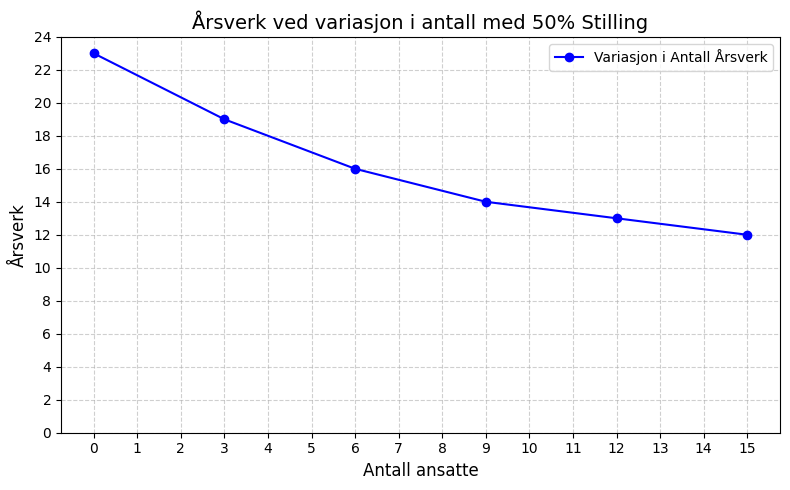

In [6]:
import matplotlib.pyplot as plt

x = [0, 3, 6, 9, 12, 15] 
y = [23, 19, 16, 14, 13, 12] 

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue', label="Variasjon i Antall Årsverk")
plt.title("Årsverk ved variasjon i antall med 50% Stilling", fontsize=14)
plt.xlabel("Antall ansatte", fontsize=12)
plt.ylabel("Årsverk", fontsize=12)
plt.xticks(range(0, 16, 1))
plt.yticks(range(0, 25, 2))
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
employees = sorted(set(employee for employee, shift_type, day in staff_allocation.keys()))
shift_types = ["Natt", "Dag", "Kveld"]
days = sorted(set(day for employee, shift_type, day in staff_allocation.keys()))
index = pd.MultiIndex.from_product([days, shift_types], names=["Day", "Shift Type"])


df = pd.DataFrame(index=index, columns=employees)
for (employee, shift_type, day), value in staff_allocation.items():
    df.loc[(day, shift_type), employee] = value
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  

def color_cells(val):
    if pd.isna(val):
        val = 0
    return 'background-color: green' if val == 1 else 'background-color: red'

df = df.astype(int)
styled_df = df.style.applymap(color_cells)

# lagre html fil
styled_df.to_html("styled_work_schedule_30_emp_v5.html")
df.to_csv('finhf_workforce_schedule_v5.csv', index = False, encoding='utf-8')

# Etterspørselsiden

## Monte Carlo Simulering Overbelastning, Belegg, og Ventetid

### Input data

In [13]:
# Model-specific parameters
data = fin_data

## Scenarioer: 1) Helligdager og offentlige eventer, 2) Høytider, 3) Ulykke, 4) Krig
# Her må det legges til endring i pasientstrøm og belegg pr. dag i functionene direkte, pluss endring i MaxStaff, PPS, availability og service_level (fra optimeringsdelen),
# total_beds, og average_stay for å simulere de ulike scenarioene  

### Simuleringsresultater

In [14]:
data, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents = monte_carlo_simulation(data=data, 
                                                                                                                                           total_beds=total_beds, 
                                                                                                                                           average_stay= avg_length_of_stay, 
                                                                                                                                           num_simulations= iterations, 
                                                                                                                                           post= post, 
                                                                                                                                           year= year)

# Print resultater
print(f"Gjennomsnittlig antall dager med overbelastning per år: {avg_overload_days:.2f} dager")
print(f"Gjennomsnittlig beleggsprosent over året: {avg_occupancy_percentage:.2f}%")
print(f"Sannsynligheten for at pasienter må vente på en seng: {waiting_probability:.2%}")

Gjennomsnittlig antall dager med overbelastning per år: 76.10 dager
Gjennomsnittlig beleggsprosent over året: 85.47%
Sannsynligheten for at pasienter må vente på en seng: 14.24%


### Visualiserte resultater

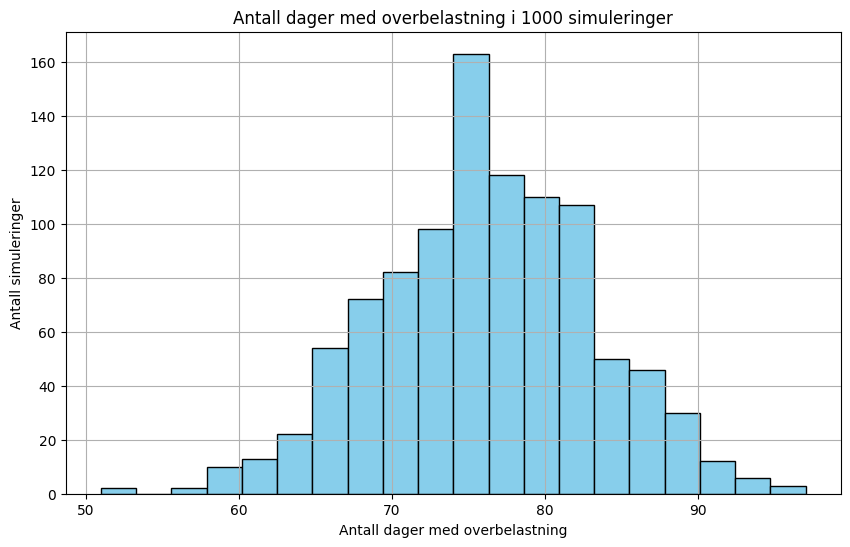

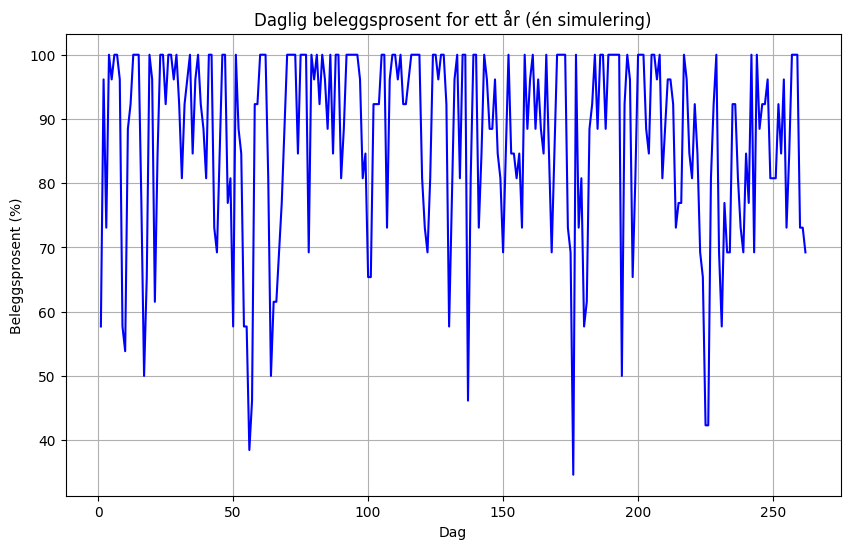

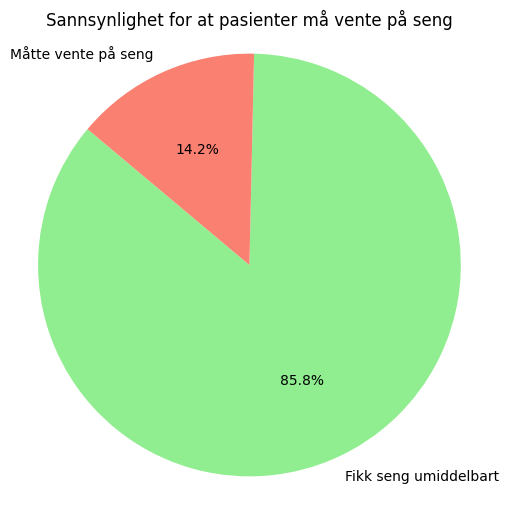

In [15]:
monte_carlo_dager_overbelastning(all_overload_days)
monte_carlo_beleggsprosent(data, all_occupancy_percents)
monte_carlo_waiting_probability(waiting_probability)

## Ad-Hoc Analyser

### Analyse av størst trykk

In [9]:
fin_data_hourly_24 = fin_data_hourly[(fin_data_hourly["År"] == 2024)] # & (fin_data_hourly["post"] == "kirurgisk") & (fin_data_hourly["helg"] == 1)
fin_data_hourly_24["Demand"] = fin_data_hourly_24["Antall inn på post"] + fin_data_hourly_24["Belegg"]
fin_data_hourly_24.loc[fin_data_hourly_24['skift_type'] == 'natt', 'Demand'] *= 0.33

In [10]:
fin_data_hourly_24

,År,Måned,Uke,Dag,DatoTid,Timer,post,helg,Antall inn på post,Antall pasienter ut av Post,Belegg,skift_type,Prediksjoner pasientstrøm,Prediksjoner belegg,Demand
69725,2024,January,1,Monday,2024-01-01 00:00:00,0,kirurgisk,0,0.0,0.0,0.0,natt,NaN,NaN,0.00
69726,2024,January,1,Monday,2024-01-01 00:00:00,0,medisinsk,0,2.0,0.0,2.0,natt,NaN,NaN,1.32
69727,2024,January,1,Monday,2024-01-01 01:00:00,1,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
69728,2024,January,1,Monday,2024-01-01 01:00:00,1,medisinsk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
69729,2024,January,1,Monday,2024-01-01 02:00:00,2,kirurgisk,0,0.0,0.0,2.0,natt,NaN,NaN,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83544,2024,October,42,Monday,2024-10-14 21:00:00,21,kirurgisk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83545,2024,October,42,Monday,2024-10-14 22:00:00,22,medisinsk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83546,2024,October,42,Monday,2024-10-14 22:00:00,22,kirurgisk,0,0.0,0.0,24.0,kveld,NaN,NaN,24.00
83547,2024,October,42,Monday,2024-10-14 23:00:00,23,kirurgisk,0,0.0,0.0,24.0,natt,NaN,NaN,7.92


In [11]:
def adhoc_plot(data: pd.DataFrame, tids_granulitetsniv: str = "Timer", value: str = "Demand", skift_type: str = None, aggregation_level: str = "mean"):
    # Group by timer og post, og finn gjennomsnittet av etterspørselen
    week_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ]

    if aggregation_level == "mean":
        avg_patients_per_hour = data.groupby([tids_granulitetsniv, 'post'])[value].mean().reset_index()
    elif aggregation_level == "sum":
        if tids_granulitetsniv == "Dag":
            avg_patients_per_hour = fin_data_hourly_24.groupby([tids_granulitetsniv, 'post'])[value].sum().reset_index()
            avg_patients_per_hour[tids_granulitetsniv] = pd.Categorical(avg_patients_per_hour[tids_granulitetsniv], categories=week_order, ordered=True)
            avg_patients_per_hour = avg_patients_per_hour.sort_values(tids_granulitetsniv)
        else:
            avg_patients_per_hour = data.groupby([tids_granulitetsniv, 'post'])[value].sum().reset_index()
    
    if skift_type is None:
        avg = data[value].mean()    
    else:
        avg = data[data["skift_type"] == skift_type][value].mean()
    print(f"Gjennomsnittlig {value} målt i {tids_granulitetsniv}: {avg} pasienter pr {tids_granulitetsniv}")
   
    # Pivot for lettere plotting
    pivot_data = avg_patients_per_hour.pivot(index=tids_granulitetsniv, columns='post', values=value)
    pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue','salmon'])
    plt.title(f"Gjennomsnittlig {value} per post i 2024")
    plt.xlabel(f"{tids_granulitetsniv} i tidsperioden")
    plt.ylabel("Gjennomsnittlig antall pasienter")
    plt.xticks(rotation=0)
    plt.legend(title="Post")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Gjennomsnittlig Antall pasienter ut av Post målt i Dag: 0.4125434027777778 pasienter pr Dag


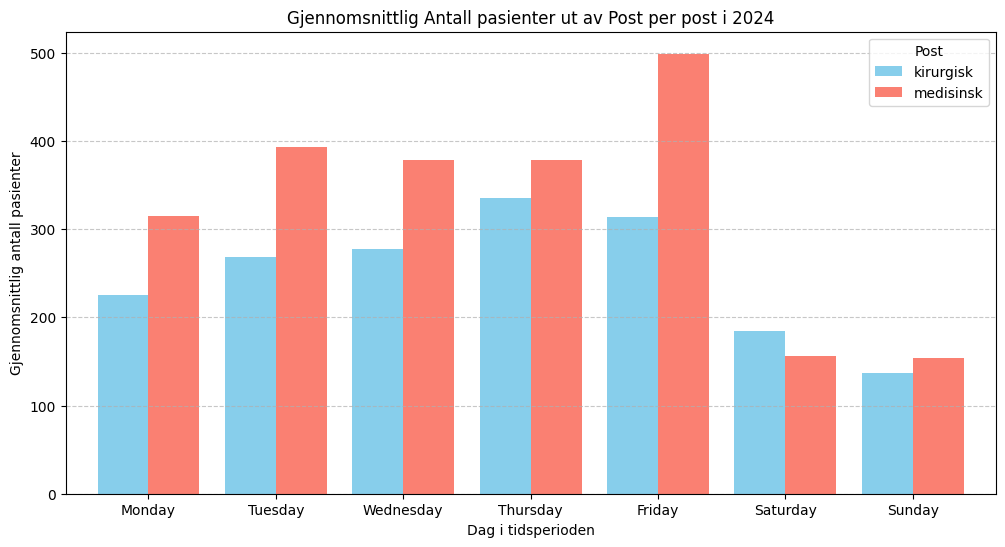

In [13]:
avg = adhoc_plot(data=fin_data_hourly_24, tids_granulitetsniv="Dag", value="Antall pasienter ut av Post", skift_type="dag", aggregation_level="sum")

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
avg_patients_per_hour = fin_data_hourly_24.groupby(['Dag', 'post'])['Demand'].mean().reset_index()
display(avg_patients_per_hour)
# Pivot for lettere plotting
# pivot_data = avg_patients_per_hour.pivot(index='Måned', columns='post', values='Antall pasienter ut av Post')
# pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue','salmon'])
# plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
# plt.xlabel("Time på dagen")
# plt.ylabel("Gjennomsnittlig antall pasienter")
# plt.xticks(rotation=0)
# plt.legend(title="Post")
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.show()


,Dag,post,Demand
0,Friday,kirurgisk,13.588902
1,Friday,medisinsk,13.587266
2,Monday,kirurgisk,17.292173
3,Monday,medisinsk,17.367708
4,Saturday,kirurgisk,11.135020
5,Saturday,medisinsk,11.190783
6,Sunday,kirurgisk,13.405600
7,Sunday,medisinsk,13.328974
8,Thursday,kirurgisk,17.183313
9,Thursday,medisinsk,17.333171


In [57]:
fin_data_hourly_24[fin_data_hourly_24["skift_type"] == "dag"]["Demand"].mean()

22.193359375

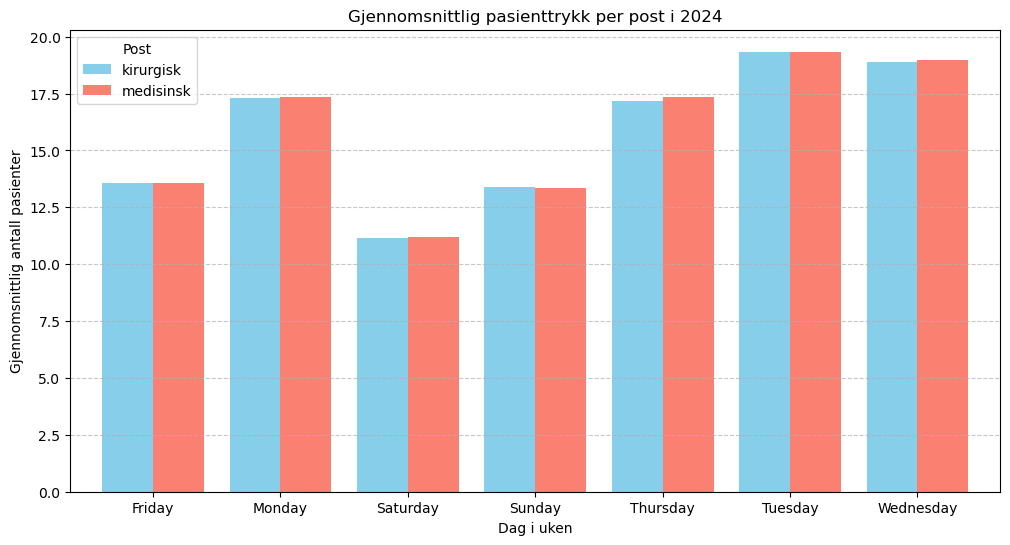

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
week_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]
avg_patients_per_hour = fin_data_hourly_24.groupby(['Dag', 'post'])['Demand'].mean().reset_index()
avg_patients_per_hour['Dag'] = pd.Categorical(avg_patients_per_hour['Dag'], categories=week_order, ordered=True)
avg_patients_per_hour = avg_patients_per_hour.sort_values('Dag')

# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Dag', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Dag i uken")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


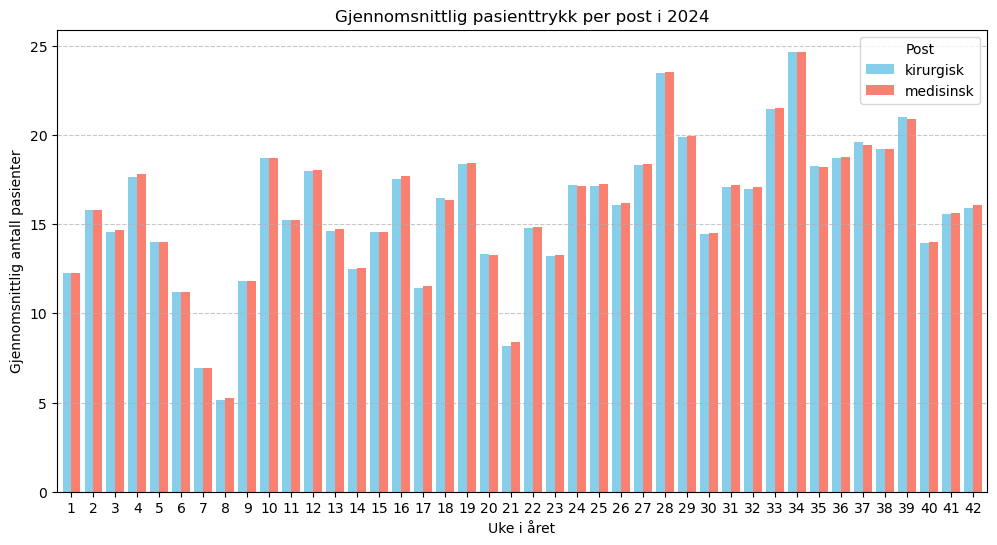

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
avg_patients_per_hour = fin_data_hourly_24.groupby(['Uke', 'post'])['Demand'].mean().reset_index()

# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Uke', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Uke i året")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


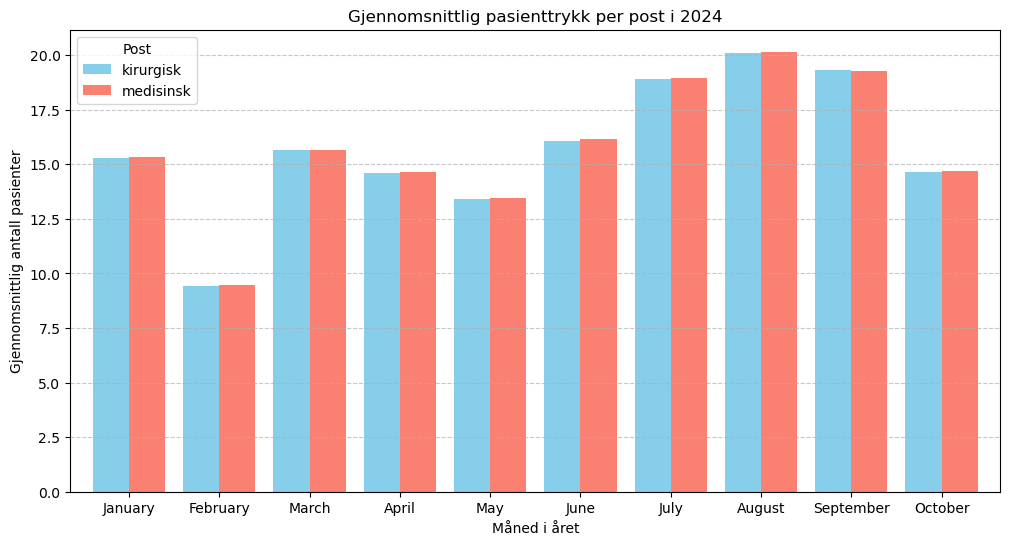

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by timer og post, og finn gjennomsnittet av etterspørselen
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
avg_patients_per_hour = fin_data_hourly_24.groupby(['Måned', 'post'])['Demand'].mean().reset_index()
avg_patients_per_hour['Måned'] = pd.Categorical(avg_patients_per_hour['Måned'], categories=month_order, ordered=True)
avg_patients_per_hour = avg_patients_per_hour.sort_values('Måned')
# Pivot for lettere plotting
pivot_data = avg_patients_per_hour.pivot(index='Måned', columns='post', values='Demand')
pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Gjennomsnittlig pasienttrykk per post i 2024")
plt.xlabel("Måned i året")
plt.ylabel("Gjennomsnittlig antall pasienter")
plt.xticks(rotation=0)
plt.legend(title="Post")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
